In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

years = range(2002,2018)
current_year_columns = ['FantasyPointsPerGame','PassingYards', 'PassingTouchdowns', 'PassingInterceptions', 'Played', 'RushingYards','RushingTouchdowns','Receptions','ReceivingYards','ReceivingTouchdowns','FumblesLost']
prev_year_columns = ['PrevPPG', 'PrevPassingYards','PrevPassingTouchdowns','PrevPassingInterceptions','PrevPlayed', 'PrevRushingYards','PrevRushingTouchdowns','PrevReceptions','PrevReceivingYards','PrevReceivingTouchdowns','PrevFumblesLost']
rolling_columns = ['RollingPPG', 'RollingPassingYards','RollingPassingTouchdowns','RollingPassingInterceptions','RollingPlayed', 'RollingRushingYards','RollingRushingTouchdowns','RollingReceptions','RollingReceivingYards','RollingReceivingTouchdowns','RollingFumblesLost']
feature_columns = rolling_columns + ['YearsInLeague']
target_column = 'FantasyPointsPerGame'



year_dfs = []
for year in years:
    year_df = pd.read_csv('./datasets/fantasy-football-leaders-{}.csv'.format(year))
    year_df['Year'] = year
    year_dfs.append(year_df)

all_players = pd.concat(year_dfs)
players_2017 = all_players[all_players['Year'] == 2017]['Name'].values
players_2017 = np.append(players_2017, ['David Johnson'])
players_2018 = {'Name': players_2017, 'Year': [2018] * len(players_2017)}
players_2018_df = pd.DataFrame(data=players_2018)
all_players = pd.concat([all_players, players_2018_df])

all_players = all_players.sort_values(['Name', 'Year'])
same_player_boolean_mask = all_players['Name'].shift() == all_players['Name']
all_players[prev_year_columns] = all_players[current_year_columns].shift()
all_players = all_players[same_player_boolean_mask]
all_players = all_players.set_index('Name')
all_players['RookieYear'] = all_players.groupby('Name')['Year'].min() - 1
all_players.reset_index(inplace=True)
all_players['YearsInLeague'] = all_players['Year'] - all_players['RookieYear']

In [176]:
all_players = all_players.set_index('Name')
all_players[rolling_columns] = all_players.groupby('Name')[prev_year_columns].rolling(1).mean().reset_index(0, drop=True)
all_players.reset_index(inplace=True)

new_players = all_players[all_players["Year"] == 2018] #save new 2018 players for prediction
new_players = new_players.dropna(subset=["RollingPPG"])

all_players = all_players.dropna()
all_players = all_players[all_players["Year"] != 2018] #remove 2018 players from training set


In [127]:
# new_players

In [67]:
## KNN Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = all_players['RollingPPG'].values.reshape(-1,1)
y = all_players['FantasyPointsPerGame'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
knnreg = KNeighborsRegressor(n_neighbors = 6).fit(X_train, y_train)
print('R-squared test score: {:.3f}'
     .format(knnreg.score(X_test, y_test)))


R-squared test score: 0.498


In [68]:
## Linear Regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [[ 0.80979862]]
linear model intercept (b): [ 1.20041569]
R-squared score (training): 0.570
R-squared score (test): 0.564


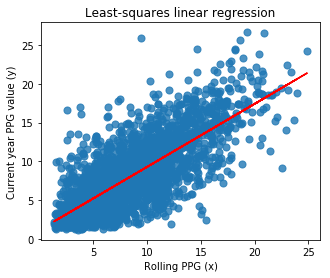

In [69]:
plt.figure(figsize=(5,4))
plt.scatter(X, y, marker= 'o', s=50, alpha=0.8)
plt.plot(X, linreg.coef_ * X + linreg.intercept_, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('Rolling PPG (x)')
plt.ylabel('Current year PPG value (y)')
plt.show()

In [151]:
## Ridge regression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.linear_model import Ridge

X = all_players[feature_columns].values
y = all_players['FantasyPointsPerGame'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=1).fit(X_train_scaled, y_train)

print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))

ridge regression linear model intercept: [ 3.91408713]
ridge regression linear model coeff:
[[ 11.08264159   6.65763004   2.24450818   0.54405065  -1.36358108
    3.64945624   0.69945461   0.23768429   4.17637086  -0.55657036
    0.11612684  -1.76108435]]
R-squared score (training): 0.599
R-squared score (test): 0.582
Number of non-zero features: 12


In [152]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Lasso

X = all_players[feature_columns].values
y = all_players['FantasyPointsPerGame'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=0.0001, max_iter=60000).fit(X_train_scaled, y_train)

print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))

lasso regression linear model intercept: [ 3.74278207]
lasso regression linear model coeff:
[ 11.97144715   8.68495549  -0.27280689  -0.33973266  -1.17840231
   3.62912577  -0.          -0.3935416    4.77715349  -1.03555182
  -0.03950602  -1.85963712]
R-squared score (training): 0.600
R-squared score (test): 0.580
Number of non-zero features: 11


In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

X = all_players[feature_columns].values
y = all_players['FantasyPointsPerGame'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

linreg = LinearRegression().fit(X_train, y_train)

print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

print('\nNow we transform the original input data to add\n\
polynomial features up to degree 2 (quadratic)\n')
poly = PolynomialFeatures(degree=2)
X_F1_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y,
                                                   random_state = 0)
linreg = LinearRegression().fit(X_train, y_train)

print('(poly deg 2) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2) linear model intercept (b): {}'
     .format(linreg.intercept_))
print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test, y_test)))

print('\nAddition of many polynomial features often leads to\n\
overfitting, so we often use polynomial features in combination\n\
with regression that has a regularization penalty, like ridge\n\
regression.\n')

X_train, X_test, y_train, y_test = train_test_split(X_F1_poly, y,
                                                   random_state = 0)
linreg = Ridge().fit(X_train, y_train)

print('(poly deg 2 + ridge) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2 + ridge) linear model intercept (b): {}'
     .format(linreg.intercept_))
print('(poly deg 2 + ridge) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('(poly deg 2 + ridge) R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))

linear model coeff (w): [[  5.04692123e-01   1.68975893e-03  -1.07429007e-02  -1.88490232e-02
   -9.25251686e-02   2.03581897e-03  -2.55509124e-04  -3.51516751e-03
    2.68300323e-03  -6.97181922e-02  -7.53616161e-03  -1.33126696e-01]]
linear model intercept (b): [ 3.59581416]
R-squared score (training): 0.600
R-squared score (test): 0.580

Now we transform the original input data to add
polynomial features up to degree 2 (quadratic)

(poly deg 2) linear model coeff (w):
[[ -7.60482725e-11  -3.44142946e-01   1.07264845e-02  -1.09696495e+00
    2.41744359e-01  -1.78134305e+00   2.08390956e-03   3.46647202e-01
    3.40240909e-01  -2.73123450e-02   1.63229016e+00  -7.04280172e-01
   -5.93281639e-01  -3.26852811e-02  -5.31756868e-04   9.66641422e-02
    5.21354976e-02   5.25647795e-02   1.52621570e-03  -3.35580701e-02
   -4.56545445e-02   5.75619853e-03  -2.23337601e-01   8.43834800e-02
    4.89632865e-02  -6.43830688e-07   1.83356837e-04   8.98821934e-05
   -9.85152973e-05  -3.24863782e-0

In [73]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# fix random seed for reproducibility
seed = 7

# define base model
def baseline_model():    
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [74]:
# fix random seed for reproducibility
numpy.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)

kfold  = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -10.26 (1.64) MSE


In [75]:


# evaluate model with standardized dataset
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


Standardized: -8.74 (1.28) MSE


In [76]:
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [77]:
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger: -8.68 (1.24) MSE


In [78]:
# wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [79]:
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Wider: -8.71 (1.26) MSE


In [91]:
## Final Model
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
pipeline.fit(X, y)

Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasRegressor object at 0x1235e5908>)])

In [130]:
new_players['2018_PPG_pred'] = pipeline.predict(new_players[feature_columns].values)
output = new_players[['Name','2018_PPG_pred']].sort_values('2018_PPG_pred', ascending=False)
output.set_index("Name", inplace=True)
output.to_csv('2018_ppg_preds_rolling_2.csv')



In [177]:
all_players[all_players['Name'].str.contains('David Johnson')]

,Name,FantasyPoints,FantasyPointsPerGame,FumblesLost,PassingInterceptions,PassingTouchdowns,PassingYards,Played,Position,ReceivingTouchdowns,...,RollingPassingYards,RollingPassingTouchdowns,RollingPassingInterceptions,RollingPlayed,RollingRushingYards,RollingRushingTouchdowns,RollingReceptions,RollingReceivingYards,RollingReceivingTouchdowns,RollingFumblesLost
996,David Johnson,327.8,20.5,3.0,0.0,0.0,0.0,16.0,RB,4.0,...,0.0,0.0,0.0,16.0,581.0,8.0,36.0,457.0,4.0,1.0


In [178]:
pipeline.predict(all_players[all_players['Name'] == 'David Johnson'][feature_columns].values)

array(9.878677368164062, dtype=float32)